# 🚗 계층적 분류 모델 (Hierarchical Classification)

이 노트북에서는 계층적 분류 접근법으로 차량 사운드를 분류합니다.

## 📋 목차
1. **1단계 모델**: 상태(State) 분류 - 브레이크/공회전/시동
2. **군집 분석**: PCA 시각화 + K-means 클러스터링
3. **2단계 모델**: 각 상태별 세부 문제 분류
   - 브레이크 상태 세부 분류
   - 공회전 상태 세부 분류
   - 시동 상태 세부 분류


In [1]:
# ============================================================
# 필수 라이브러리 임포트
# ============================================================

import os
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# 머신러닝
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    adjusted_rand_score, normalized_mutual_info_score,
    silhouette_score
)
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa

# 프로젝트 모듈
from app.ml.models.crnn import SoundClassifierCRNN
from app.ml.features.extractor import AudioFeatureExtractor, AudioConfig
from app.ml.features.augmentation import AudioAugmentor, AugmentationConfig
from app.ml.training.trainer import Trainer, create_optimizer, create_scheduler

# 시각화 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ 라이브러리 로드 완료!")
print(f"🖥️ Device: {device}")


✅ 라이브러리 로드 완료!
🖥️ Device: cpu


---
## 1. 데이터 로드 및 전처리


In [2]:
# ============================================================
# 데이터 경로 수집
# ============================================================

data_dir = Path('../data')
augmented_dir = data_dir / 'augmented'

# 파일 경로와 레이블 수집
all_files = []
all_states = []      # 1단계: 상태 (braking, idle, startup)
all_problems = []    # 2단계: 세부 문제

# 상태 매핑
state_mapping = {
    'braking state': 0,
    'idle state': 1,
    'startup state': 2
}
state_names = ['braking', 'idle', 'startup']

print("📂 데이터 로드 중...")

# 원본 데이터 수집
for state_dir in sorted(data_dir.iterdir()):
    if not state_dir.is_dir() or state_dir.name == 'augmented':
        continue
    
    state_name = state_dir.name
    state_idx = state_mapping.get(state_name, -1)
    
    if state_idx == -1:
        continue
    
    for problem_dir in sorted(state_dir.iterdir()):
        if not problem_dir.is_dir():
            continue
        
        problem_name = problem_dir.name
        
        # WAV 파일 수집
        wav_files = list(problem_dir.glob('*.wav'))
        for f in wav_files:
            all_files.append(f)
            all_states.append(state_idx)
            all_problems.append(f"{state_name}/{problem_name}")
        
        # 하위 폴더도 확인 (combined 등)
        for sub_dir in problem_dir.iterdir():
            if sub_dir.is_dir():
                sub_files = list(sub_dir.glob('*.wav'))
                for f in sub_files:
                    all_files.append(f)
                    all_states.append(state_idx)
                    all_problems.append(f"{state_name}/{problem_name}/{sub_dir.name}")

original_count = len(all_files)
print(f"   원본 샘플: {original_count}개")

# 증강 데이터 수집
if augmented_dir.exists():
    for state_dir in sorted(augmented_dir.iterdir()):
        if not state_dir.is_dir():
            continue
        
        state_name = state_dir.name
        state_idx = state_mapping.get(state_name, -1)
        
        if state_idx == -1:
            continue
        
        for problem_dir in sorted(state_dir.iterdir()):
            if not problem_dir.is_dir():
                continue
            
            problem_name = problem_dir.name
            
            # 증강 WAV 파일 수집
            aug_files = list(problem_dir.glob('*.wav'))
            for f in aug_files:
                all_files.append(f)
                all_states.append(state_idx)
                all_problems.append(f"{state_name}/{problem_name}")
            
            # 하위 폴더도 확인
            for sub_dir in problem_dir.iterdir():
                if sub_dir.is_dir():
                    sub_files = list(sub_dir.glob('*.wav'))
                    for f in sub_files:
                        all_files.append(f)
                        all_states.append(state_idx)
                        all_problems.append(f"{state_name}/{problem_name}/{sub_dir.name}")

augmented_count = len(all_files) - original_count
print(f"   증강 샘플: {augmented_count}개")

print("\n" + "=" * 50)
print(f"📊 총 데이터: {len(all_files)}개")
print("=" * 50)

# 상태별 분포 확인
state_counts = Counter(all_states)
print("\n📊 상태별 분포:")
for idx, name in enumerate(state_names):
    print(f"  [{idx}] {name}: {state_counts[idx]}개")


📂 데이터 로드 중...
   원본 샘플: 1386개
   증강 샘플: 2757개

📊 총 데이터: 4143개

📊 상태별 분포:
  [0] braking: 612개
  [1] idle: 2631개
  [2] startup: 900개


In [3]:
# ============================================================
# 피처 추출기 초기화
# ============================================================

audio_config = AudioConfig(
    sample_rate=22050,
    duration=5.0,
    n_mels=128,
    n_mfcc=40,
    n_fft=2048,
    hop_length=512
)

feature_extractor = AudioFeatureExtractor(config=audio_config)
print("✅ 피처 추출기 초기화 완료!")


✅ 피처 추출기 초기화 완료!


In [4]:
# ============================================================
# 피처 추출 (군집 분석용)
# ============================================================

print("🔄 피처 추출 중... (시간이 걸릴 수 있습니다)")

# 모든 샘플에서 피처 추출
all_features = []

for file_path in tqdm(all_files, desc="피처 추출"):
    try:
        # CNN용 피처 추출 (Mel Spectrogram)
        features = feature_extractor.extract_for_cnn(str(file_path))
        # Flatten하여 1D 벡터로 변환
        features_flat = features.flatten()
        all_features.append(features_flat)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        # 오류 시 0으로 채움
        all_features.append(np.zeros(128 * 216))

# NumPy 배열로 변환
X = np.array(all_features)
y_state = np.array(all_states)

print(f"\n✅ 피처 추출 완료!")
print(f"   X shape: {X.shape}")
print(f"   y_state shape: {y_state.shape}")


🔄 피처 추출 중... (시간이 걸릴 수 있습니다)


피처 추출: 100%|██████████| 4143/4143 [01:29<00:00, 46.42it/s]



✅ 피처 추출 완료!
   X shape: (4143, 27648)
   y_state shape: (4143,)


### 🔬 다양한 피처 추출 방식 비교

여러 가지 피처 추출 방식으로 PCA를 수행하여 어떤 피처가 클래스를 가장 잘 분리하는지 비교합니다.

| 피처 | 차원 | 특성 |
|-----|-----|------|
| Mel Spectrogram | 128 × T | 주파수-시간 전체 패턴 |
| MFCC | 40 × T | 스펙트럼의 음색 특성 |
| MFCC + Delta | 120 × T | 음색 + 시간적 변화 |
| Chroma | 12 × T | 12개 음계 기반 |
| Spectral Contrast | 7 × T | 주파수 대역별 대비 |
| Spectral Features | 5 × T | 통계적 특성 |
| Combined (통합) | 모두 결합 | 종합 피처 |


In [ ]:
# ============================================================
# 다양한 피처 추출 함수 정의
# ============================================================

def extract_multiple_features(file_path, feature_extractor, sr=22050):
    """
    다양한 피처를 추출하는 함수
    
    Returns:
        dict: 각 피처 종류별 추출된 값
    """
    # 오디오 로드
    y, sr = feature_extractor.load_audio(str(file_path))
    
    features = {}
    
    # 1. Mel Spectrogram (기본)
    mel_spec = feature_extractor.extract_mel_spectrogram(y, sr)
    features['mel_spectrogram'] = mel_spec.flatten()
    
    # 2. MFCC (Delta 없이)
    mfcc = feature_extractor.extract_mfcc(y, sr, include_delta=False)
    features['mfcc'] = mfcc.flatten()
    
    # 3. MFCC + Delta + Delta2
    mfcc_delta = feature_extractor.extract_mfcc(y, sr, include_delta=True)
    features['mfcc_delta'] = mfcc_delta.flatten()
    
    # 4. Chroma
    chroma = feature_extractor.extract_chroma(y, sr)
    features['chroma'] = chroma.flatten()
    
    # 5. Spectral Contrast
    contrast = feature_extractor.extract_spectral_contrast(y, sr)
    features['spectral_contrast'] = contrast.flatten()
    
    # 6. Spectral Features (통계적 특성)
    spectral = feature_extractor.extract_spectral_features(y, sr)
    spectral_combined = np.concatenate([
        spectral['spectral_centroid'].flatten(),
        spectral['spectral_bandwidth'].flatten(),
        spectral['spectral_rolloff'].flatten(),
        spectral['zero_crossing_rate'].flatten(),
        spectral['rms'].flatten()
    ])
    features['spectral_features'] = spectral_combined
    
    # 7. 통계 기반 피처 (평균, 표준편차)
    mel_stats = np.concatenate([
        mel_spec.mean(axis=1),  # 각 Mel 밴드의 평균
        mel_spec.std(axis=1),   # 각 Mel 밴드의 표준편차
        mel_spec.max(axis=1),   # 각 Mel 밴드의 최대값
        mel_spec.min(axis=1)    # 각 Mel 밴드의 최소값
    ])
    features['mel_stats'] = mel_stats
    
    mfcc_stats = np.concatenate([
        mfcc.mean(axis=1),
        mfcc.std(axis=1),
        mfcc.max(axis=1),
        mfcc.min(axis=1)
    ])
    features['mfcc_stats'] = mfcc_stats
    
    # 8. Combined (모든 통계 피처 결합)
    features['combined_stats'] = np.concatenate([
        mel_stats,
        mfcc_stats,
        chroma.mean(axis=1),
        chroma.std(axis=1),
        contrast.mean(axis=1),
        contrast.std(axis=1),
        spectral_combined.mean(keepdims=True) if spectral_combined.ndim > 0 else spectral_combined
    ])
    
    return features

print("✅ 다양한 피처 추출 함수 정의 완료!")


In [ ]:
# ============================================================
# 모든 피처 추출 (다양한 방식)
# ============================================================

print("🔄 다양한 피처 추출 중... (시간이 걸릴 수 있습니다)")

# 피처 저장용 딕셔너리
feature_dict = {
    'mel_spectrogram': [],
    'mfcc': [],
    'mfcc_delta': [],
    'chroma': [],
    'spectral_contrast': [],
    'spectral_features': [],
    'mel_stats': [],
    'mfcc_stats': [],
    'combined_stats': []
}

# 샘플링 (전체 데이터가 너무 많으면 일부만 사용)
MAX_SAMPLES = min(1000, len(all_files))  # 최대 1000개 샘플
sample_indices = np.random.choice(len(all_files), MAX_SAMPLES, replace=False)
sampled_files = [all_files[i] for i in sample_indices]
sampled_states = [all_states[i] for i in sample_indices]

print(f"   샘플링: {len(all_files)}개 중 {MAX_SAMPLES}개 사용")

for file_path in tqdm(sampled_files, desc="다양한 피처 추출"):
    try:
        features = extract_multiple_features(file_path, feature_extractor)
        for key in feature_dict.keys():
            feature_dict[key].append(features[key])
    except Exception as e:
        print(f"Error: {file_path.name} - {e}")
        # 오류 시 0으로 채움
        for key in feature_dict.keys():
            if len(feature_dict[key]) > 0:
                feature_dict[key].append(np.zeros_like(feature_dict[key][-1]))

# NumPy 배열로 변환
for key in feature_dict.keys():
    feature_dict[key] = np.array(feature_dict[key])

y_sampled = np.array(sampled_states)

print(f"\n✅ 다양한 피처 추출 완료!")
print("\n📊 피처별 차원:")
for key, value in feature_dict.items():
    print(f"   {key}: {value.shape}")


In [ ]:
# ============================================================
# 모든 피처에 대해 PCA 수행 및 시각화
# ============================================================

def visualize_pca_comparison(feature_dict, y_labels, state_names):
    """모든 피처에 대해 PCA 2D 시각화 비교"""
    
    n_features = len(feature_dict)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten()
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    markers = ['o', 's', '^']
    
    pca_results = {}
    
    for idx, (feature_name, X_feat) in enumerate(feature_dict.items()):
        ax = axes[idx]
        
        # 정규화
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_feat)
        
        # PCA
        pca = PCA(n_components=2, random_state=42)
        X_pca = pca.fit_transform(X_scaled)
        
        # 저장
        pca_results[feature_name] = {
            'X_pca': X_pca,
            'explained_variance': pca.explained_variance_ratio_.sum(),
            'X_scaled': X_scaled
        }
        
        # 시각화
        for state_idx, (name, color, marker) in enumerate(zip(state_names, colors, markers)):
            mask = y_labels == state_idx
            ax.scatter(
                X_pca[mask, 0], X_pca[mask, 1],
                c=color, marker=marker,
                label=name, alpha=0.6, s=40
            )
        
        explained = pca.explained_variance_ratio_.sum() * 100
        ax.set_title(f'{feature_name}\n(설명 분산: {explained:.1f}%)', fontsize=11, fontweight='bold')
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # 빈 축 숨기기
    for idx in range(len(feature_dict), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('🔬 피처별 PCA 2D 시각화 비교', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    return pca_results

# PCA 시각화 수행
pca_results = visualize_pca_comparison(feature_dict, y_sampled, state_names)


In [ ]:
# ============================================================
# 피처별 클러스터링 성능 비교
# ============================================================

def compare_clustering_performance(feature_dict, y_labels, state_names):
    """각 피처에 대해 K-means 클러스터링 성능 비교"""
    
    results = []
    
    for feature_name, X_feat in feature_dict.items():
        # 정규화
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_feat)
        
        # K-means 클러스터링
        kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_scaled)
        
        # 성능 평가
        silhouette = silhouette_score(X_scaled, cluster_labels)
        ari = adjusted_rand_score(y_labels, cluster_labels)
        nmi = normalized_mutual_info_score(y_labels, cluster_labels)
        
        results.append({
            'Feature': feature_name,
            'Silhouette': silhouette,
            'ARI': ari,
            'NMI': nmi,
            'Dimension': X_feat.shape[1]
        })
    
    return pd.DataFrame(results)

# 클러스터링 성능 비교
df_results = compare_clustering_performance(feature_dict, y_sampled, state_names)

# 결과 정렬 (ARI 기준)
df_results_sorted = df_results.sort_values('ARI', ascending=False)

print("=" * 70)
print("📊 피처별 클러스터링 성능 비교 (K-means, k=3)")
print("=" * 70)
print(df_results_sorted.to_string(index=False))
print("\n💡 ARI (Adjusted Rand Index)가 높을수록 실제 레이블과 일치도가 높습니다.")


In [ ]:
# ============================================================
# 성능 비교 시각화
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 결과를 피처 이름 순서대로 정렬
df_plot = df_results.sort_values('ARI', ascending=True)

# 1. Silhouette Score
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(df_plot)))
axes[0].barh(df_plot['Feature'], df_plot['Silhouette'], color=colors)
axes[0].set_xlabel('Silhouette Score')
axes[0].set_title('🔵 군집 응집도 (Silhouette)', fontweight='bold')
axes[0].axvline(x=0, color='gray', linestyle='--', alpha=0.5)

# 2. Adjusted Rand Index
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(df_plot)))
axes[1].barh(df_plot['Feature'], df_plot['ARI'], color=colors)
axes[1].set_xlabel('Adjusted Rand Index')
axes[1].set_title('🎯 레이블 일치도 (ARI)', fontweight='bold')

# 3. NMI
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(df_plot)))
axes[2].barh(df_plot['Feature'], df_plot['NMI'], color=colors)
axes[2].set_xlabel('Normalized Mutual Information')
axes[2].set_title('📊 정보 공유도 (NMI)', fontweight='bold')

plt.suptitle('📈 피처별 클러스터링 성능 비교', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 최고 성능 피처 출력
best_feature = df_results.loc[df_results['ARI'].idxmax(), 'Feature']
best_ari = df_results['ARI'].max()
print(f"\n🏆 최고 성능 피처: {best_feature} (ARI: {best_ari:.4f})")


In [ ]:
# ============================================================
# 최고 성능 피처로 3D PCA 시각화
# ============================================================

from mpl_toolkits.mplot3d import Axes3D

# 최고 성능 피처 선택
best_feature = df_results.loc[df_results['ARI'].idxmax(), 'Feature']
X_best = feature_dict[best_feature]

# 정규화 및 3D PCA
scaler = StandardScaler()
X_best_scaled = scaler.fit_transform(X_best)

pca_3d = PCA(n_components=3, random_state=42)
X_best_3d = pca_3d.fit_transform(X_best_scaled)

# 3D 시각화
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
markers = ['o', 's', '^']

for state_idx, (name, color, marker) in enumerate(zip(state_names, colors, markers)):
    mask = y_sampled == state_idx
    ax.scatter(
        X_best_3d[mask, 0],
        X_best_3d[mask, 1],
        X_best_3d[mask, 2],
        c=color, marker=marker,
        label=f'{name} (n={mask.sum()})',
        alpha=0.6, s=50
    )

explained = pca_3d.explained_variance_ratio_.sum() * 100
ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})')
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})')
ax.set_title(f'🏆 최고 성능 피처 3D PCA: {best_feature}\n(총 설명 분산: {explained:.1f}%)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best')

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# 추가 피처: 시간-주파수 통계 피처
# ============================================================

def extract_advanced_features(file_path, sr=22050, duration=5.0):
    """
    고급 통계 피처 추출
    - 시간 영역 피처
    - 주파수 영역 피처
    - 켑스트럼 피처
    """
    # 오디오 로드
    y, sr = librosa.load(str(file_path), sr=sr, duration=duration)
    
    # 길이 맞추기
    target_length = int(sr * duration)
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)))
    else:
        y = y[:target_length]
    
    features = {}
    
    # === 시간 영역 피처 ===
    # RMS Energy
    rms = librosa.feature.rms(y=y)[0]
    features['rms_mean'] = rms.mean()
    features['rms_std'] = rms.std()
    features['rms_max'] = rms.max()
    
    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    features['zcr_mean'] = zcr.mean()
    features['zcr_std'] = zcr.std()
    
    # Amplitude Envelope
    features['amp_mean'] = np.abs(y).mean()
    features['amp_std'] = np.abs(y).std()
    features['amp_max'] = np.abs(y).max()
    
    # === 주파수 영역 피처 ===
    # Spectral Centroid (주파수 무게 중심)
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    features['centroid_mean'] = cent.mean()
    features['centroid_std'] = cent.std()
    
    # Spectral Bandwidth
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    features['bandwidth_mean'] = bandwidth.mean()
    features['bandwidth_std'] = bandwidth.std()
    
    # Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    features['rolloff_mean'] = rolloff.mean()
    features['rolloff_std'] = rolloff.std()
    
    # Spectral Flatness (노이즈 vs 톤)
    flatness = librosa.feature.spectral_flatness(y=y)[0]
    features['flatness_mean'] = flatness.mean()
    features['flatness_std'] = flatness.std()
    
    # === 켑스트럼 피처 (MFCC 통계) ===
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f'mfcc{i+1}_mean'] = mfcc[i].mean()
        features[f'mfcc{i+1}_std'] = mfcc[i].std()
    
    # Delta MFCC
    mfcc_delta = librosa.feature.delta(mfcc)
    for i in range(13):
        features[f'mfcc_delta{i+1}_mean'] = mfcc_delta[i].mean()
        features[f'mfcc_delta{i+1}_std'] = mfcc_delta[i].std()
    
    # === Chroma 피처 ===
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    for i in range(12):
        features[f'chroma{i+1}_mean'] = chroma[i].mean()
    
    # === Tonnetz (조성 피처) ===
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    for i in range(6):
        features[f'tonnetz{i+1}_mean'] = tonnetz[i].mean()
    
    return features

print("✅ 고급 피처 추출 함수 정의 완료!")


In [ ]:
# ============================================================
# 고급 통계 피처 추출 및 비교
# ============================================================

print("🔄 고급 통계 피처 추출 중...")

advanced_features_list = []

for file_path in tqdm(sampled_files, desc="고급 피처 추출"):
    try:
        features = extract_advanced_features(file_path)
        advanced_features_list.append(features)
    except Exception as e:
        # 오류 시 이전 값 복사
        if len(advanced_features_list) > 0:
            advanced_features_list.append(advanced_features_list[-1].copy())

# DataFrame으로 변환
df_advanced = pd.DataFrame(advanced_features_list)

# NaN 처리
df_advanced = df_advanced.fillna(0)

X_advanced = df_advanced.values

print(f"\n✅ 고급 피처 추출 완료!")
print(f"   피처 수: {X_advanced.shape[1]}개")
print(f"   샘플 수: {X_advanced.shape[0]}개")

# 피처 이름 출력
print("\n📋 추출된 피처 목록:")
for i, col in enumerate(df_advanced.columns[:20]):  # 처음 20개만
    print(f"   {i+1}. {col}")
print(f"   ... 총 {len(df_advanced.columns)}개")


In [ ]:
# ============================================================
# 고급 피처 PCA 시각화 및 클러스터링
# ============================================================

# 정규화
scaler_adv = StandardScaler()
X_advanced_scaled = scaler_adv.fit_transform(X_advanced)

# PCA
pca_adv_2d = PCA(n_components=2, random_state=42)
X_adv_pca_2d = pca_adv_2d.fit_transform(X_advanced_scaled)

# K-means
kmeans_adv = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_adv = kmeans_adv.fit_predict(X_advanced_scaled)

# 성능 평가
silhouette_adv = silhouette_score(X_advanced_scaled, cluster_adv)
ari_adv = adjusted_rand_score(y_sampled, cluster_adv)
nmi_adv = normalized_mutual_info_score(y_sampled, cluster_adv)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
markers = ['o', 's', '^']

# 좌측: 실제 레이블
for state_idx, (name, color, marker) in enumerate(zip(state_names, colors, markers)):
    mask = y_sampled == state_idx
    axes[0].scatter(
        X_adv_pca_2d[mask, 0], X_adv_pca_2d[mask, 1],
        c=color, marker=marker, label=name, alpha=0.6, s=50
    )
axes[0].set_xlabel(f'PC1 ({pca_adv_2d.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca_adv_2d.explained_variance_ratio_[1]:.1%})')
axes[0].set_title('✅ 고급 통계 피처 - 실제 레이블', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 우측: K-means 클러스터
for cluster_id, color in enumerate(colors):
    mask = cluster_adv == cluster_id
    axes[1].scatter(
        X_adv_pca_2d[mask, 0], X_adv_pca_2d[mask, 1],
        c=color, label=f'Cluster {cluster_id}', alpha=0.6, s=50
    )
# 중심점 표시
centers = pca_adv_2d.transform(kmeans_adv.cluster_centers_)
axes[1].scatter(centers[:, 0], centers[:, 1], c='black', marker='X', s=200, 
                edgecolors='white', linewidths=2, label='Centroids')
axes[1].set_xlabel(f'PC1')
axes[1].set_ylabel(f'PC2')
axes[1].set_title('🔵 고급 통계 피처 - K-means 클러스터', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle(f'📊 고급 통계 피처 ({X_advanced.shape[1]}개) PCA 시각화', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\n📊 고급 통계 피처 클러스터링 성능:")
print(f"   Silhouette Score: {silhouette_adv:.4f}")
print(f"   Adjusted Rand Index: {ari_adv:.4f}")
print(f"   Normalized Mutual Info: {nmi_adv:.4f}")


In [ ]:
# ============================================================
# 최종 피처 비교 요약
# ============================================================

# 고급 피처 결과 추가
df_final = df_results.copy()
df_final = pd.concat([df_final, pd.DataFrame([{
    'Feature': 'advanced_stats',
    'Silhouette': silhouette_adv,
    'ARI': ari_adv,
    'NMI': nmi_adv,
    'Dimension': X_advanced.shape[1]
}])], ignore_index=True)

# 정렬
df_final_sorted = df_final.sort_values('ARI', ascending=False)

print("=" * 80)
print("📊 전체 피처 비교 요약 (ARI 기준 정렬)")
print("=" * 80)
print(df_final_sorted.to_string(index=False))

# 시각화
fig, ax = plt.subplots(figsize=(12, 8))

# ARI 기준 막대 그래프
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(df_final_sorted)))
bars = ax.barh(df_final_sorted['Feature'], df_final_sorted['ARI'], color=colors)

# 값 표시
for bar, ari_val in zip(bars, df_final_sorted['ARI']):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{ari_val:.3f}', va='center', fontsize=10)

ax.set_xlabel('Adjusted Rand Index (ARI)', fontsize=12)
ax.set_title('🏆 피처별 클러스터링 성능 비교 (레이블 일치도)', fontsize=14, fontweight='bold')
ax.set_xlim(0, max(df_final_sorted['ARI']) * 1.15)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# 최고 성능 피처
best_overall = df_final_sorted.iloc[0]
print(f"\n🏆 최고 성능 피처: {best_overall['Feature']}")
print(f"   - ARI: {best_overall['ARI']:.4f}")
print(f"   - Silhouette: {best_overall['Silhouette']:.4f}")
print(f"   - NMI: {best_overall['NMI']:.4f}")
print(f"   - 차원: {int(best_overall['Dimension'])}개")


---
## 2. PCA 시각화 및 군집 분석


In [5]:
# ============================================================
# 데이터 정규화 및 PCA
# ============================================================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✅ 데이터 정규화 완료!")

# 2D PCA
print("🔄 PCA 수행 중...")
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

print(f"\n✅ PCA (2D) 완료!")
print(f"   설명된 분산 비율: {pca_2d.explained_variance_ratio_.sum():.4f}")
print(f"   PC1: {pca_2d.explained_variance_ratio_[0]:.4f}")
print(f"   PC2: {pca_2d.explained_variance_ratio_[1]:.4f}")


✅ 데이터 정규화 완료!
🔄 PCA 수행 중...

✅ PCA (2D) 완료!
   설명된 분산 비율: 0.6810
   PC1: 0.6206
   PC2: 0.0605


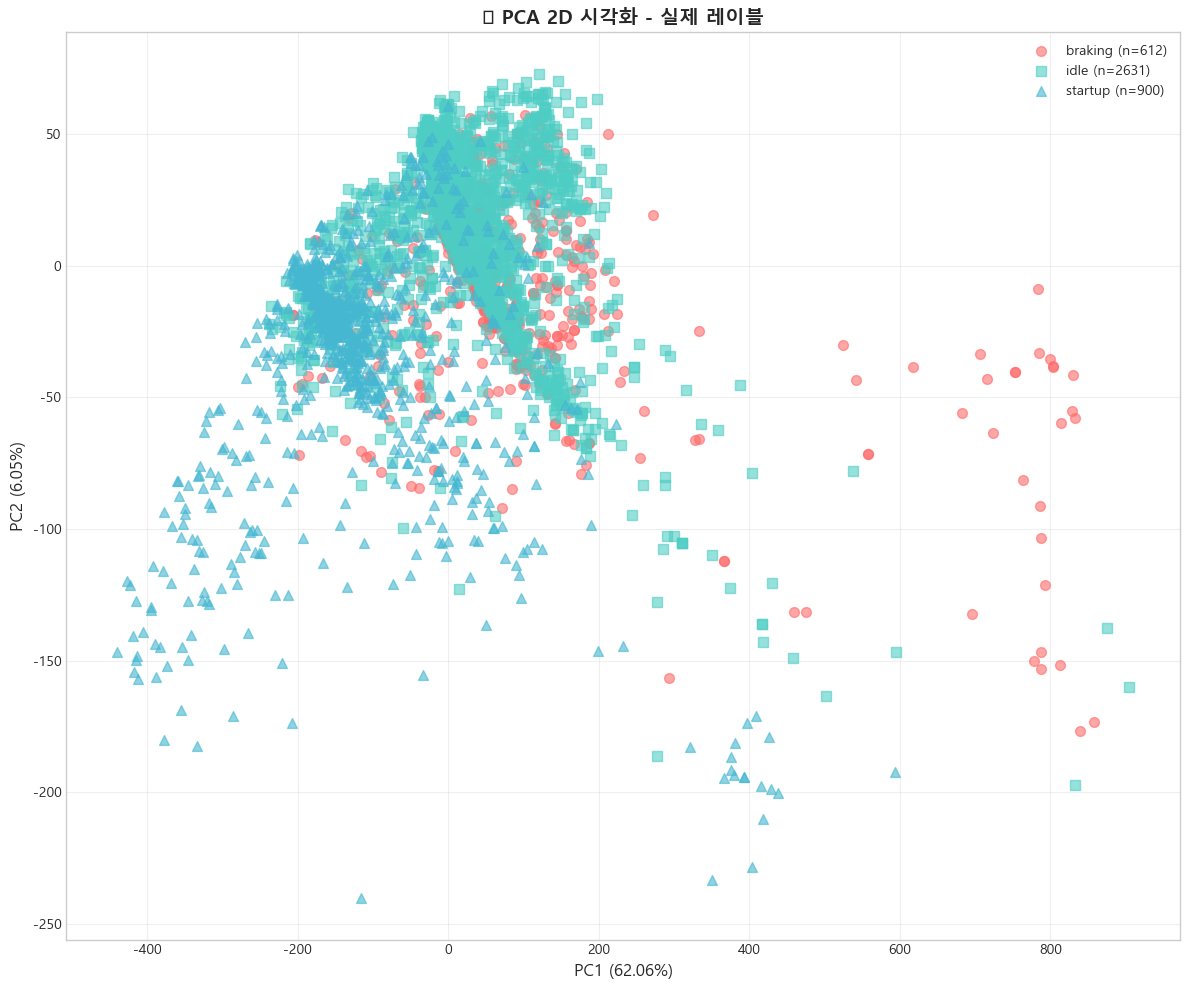


💡 해석:
  • 같은 색상(상태)의 점들이 모여있을수록 분류가 쉬움
  • 겹치는 영역이 많으면 분류가 어려울 수 있음


In [6]:
# ============================================================
# PCA 2D 시각화 (실제 레이블 기준)
# ============================================================

fig, ax = plt.subplots(figsize=(12, 10))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']  # 빨강, 청록, 파랑
markers = ['o', 's', '^']

for idx, (name, color, marker) in enumerate(zip(state_names, colors, markers)):
    mask = y_state == idx
    ax.scatter(
        X_pca_2d[mask, 0], 
        X_pca_2d[mask, 1], 
        c=color, 
        marker=marker,
        label=f'{name} (n={mask.sum()})',
        alpha=0.6,
        s=50
    )

ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%})', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%})', fontsize=12)
ax.set_title('🎯 PCA 2D 시각화 - 실제 레이블', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 해석:")
print("  • 같은 색상(상태)의 점들이 모여있을수록 분류가 쉬움")
print("  • 겹치는 영역이 많으면 분류가 어려울 수 있음")


✅ PCA (3D) 완료!
   설명된 분산 비율: 0.7202


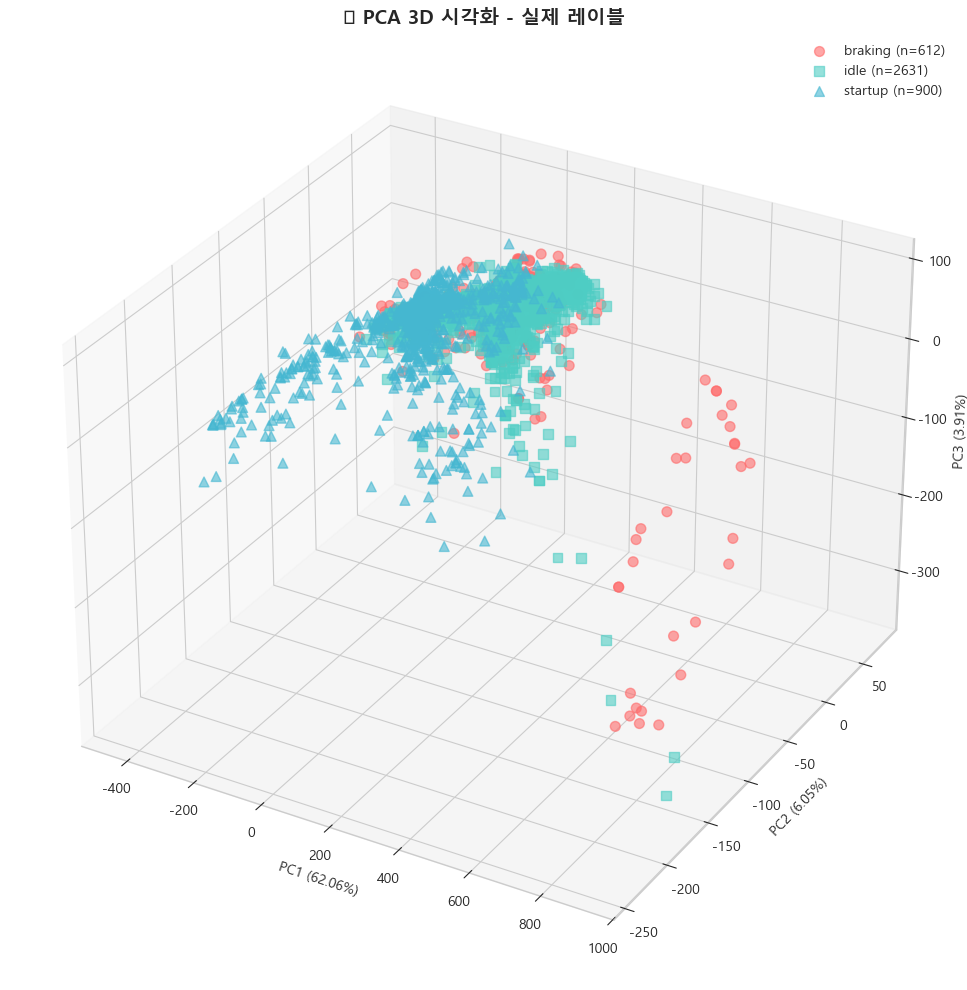

In [7]:
# ============================================================
# PCA 3D 시각화
# ============================================================

from mpl_toolkits.mplot3d import Axes3D

# 3D PCA
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_scaled)

print(f"✅ PCA (3D) 완료!")
print(f"   설명된 분산 비율: {pca_3d.explained_variance_ratio_.sum():.4f}")

# 3D 시각화
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

for idx, (name, color, marker) in enumerate(zip(state_names, colors, markers)):
    mask = y_state == idx
    ax.scatter(
        X_pca_3d[mask, 0], 
        X_pca_3d[mask, 1], 
        X_pca_3d[mask, 2],
        c=color, 
        marker=marker,
        label=f'{name} (n={mask.sum()})',
        alpha=0.6,
        s=50
    )

ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})')
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})')
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})')
ax.set_title('🎯 PCA 3D 시각화 - 실제 레이블', fontsize=14, fontweight='bold')
ax.legend(loc='best')

plt.tight_layout()
plt.show()


In [8]:
# ============================================================
# K-Means 클러스터링
# ============================================================

print("🔄 K-Means 클러스터링 수행 중...")

# K=3으로 클러스터링 (3개 상태에 맞춤)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

print(f"\n✅ K-Means 클러스터링 완료!")

# 클러스터별 분포
cluster_counts = Counter(cluster_labels)
print("\n📊 클러스터별 샘플 수:")
for cluster_id in sorted(cluster_counts.keys()):
    print(f"  Cluster {cluster_id}: {cluster_counts[cluster_id]}개")


🔄 K-Means 클러스터링 수행 중...

✅ K-Means 클러스터링 완료!

📊 클러스터별 샘플 수:
  Cluster 0: 949개
  Cluster 1: 86개
  Cluster 2: 3108개


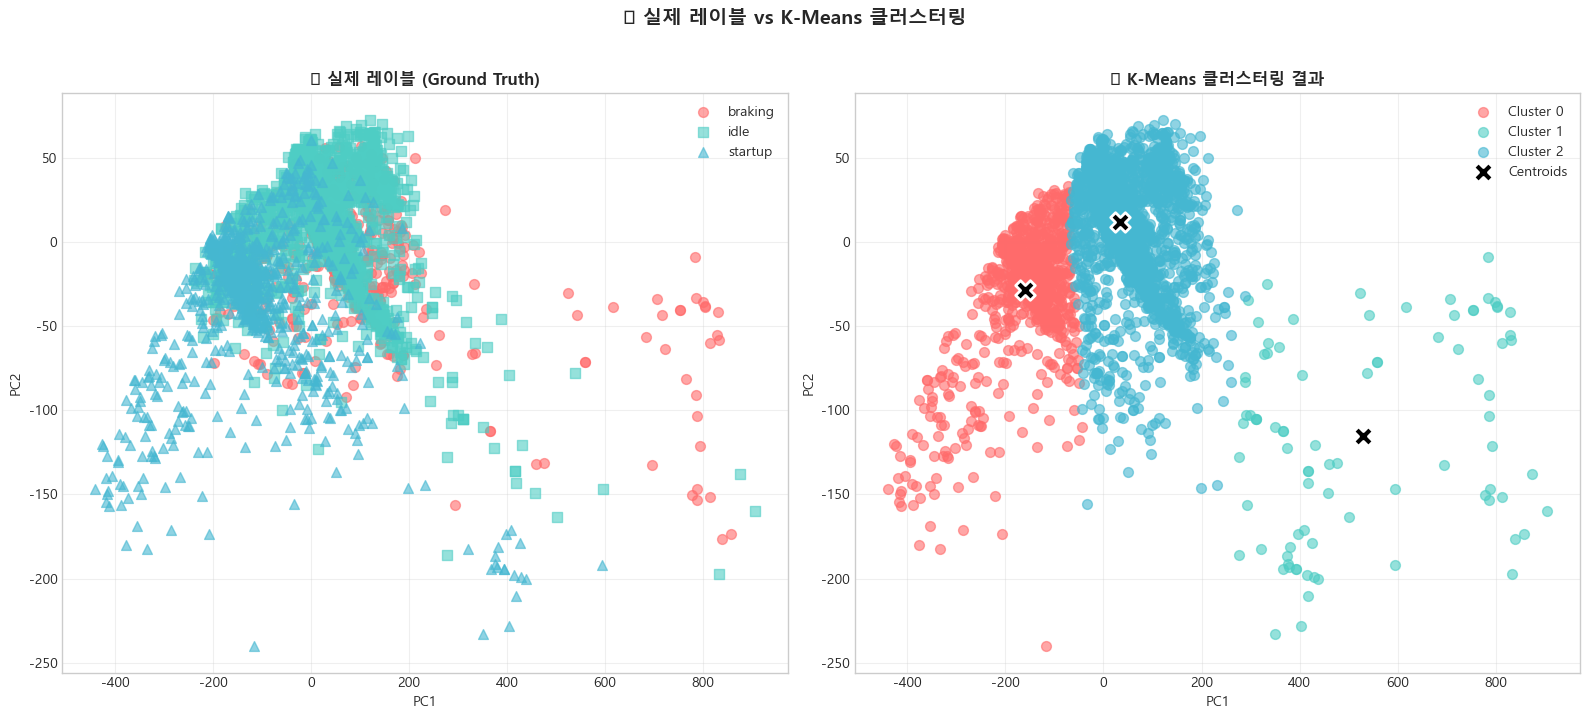

In [9]:
# ============================================================
# 클러스터링 결과 시각화
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 좌측: 실제 레이블
for idx, (name, color, marker) in enumerate(zip(state_names, colors, markers)):
    mask = y_state == idx
    axes[0].scatter(
        X_pca_2d[mask, 0], 
        X_pca_2d[mask, 1], 
        c=color, 
        marker=marker,
        label=f'{name}',
        alpha=0.6,
        s=50
    )
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('✅ 실제 레이블 (Ground Truth)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 우측: K-Means 클러스터
cluster_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
for cluster_id in range(3):
    mask = cluster_labels == cluster_id
    axes[1].scatter(
        X_pca_2d[mask, 0], 
        X_pca_2d[mask, 1], 
        c=cluster_colors[cluster_id],
        label=f'Cluster {cluster_id}',
        alpha=0.6,
        s=50
    )

# 클러스터 중심 표시
centers_pca = pca_2d.transform(kmeans.cluster_centers_)
axes[1].scatter(
    centers_pca[:, 0], centers_pca[:, 1],
    c='black', marker='X', s=200, edgecolors='white', linewidths=2,
    label='Centroids'
)

axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('🔵 K-Means 클러스터링 결과', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('📊 실제 레이블 vs K-Means 클러스터링', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [10]:
# ============================================================
# 클러스터링 성능 평가
# ============================================================

# 1. Silhouette Score (군집 응집도)
silhouette = silhouette_score(X_scaled, cluster_labels)

# 2. Adjusted Rand Index (실제 레이블과의 일치도)
ari = adjusted_rand_score(y_state, cluster_labels)

# 3. Normalized Mutual Information
nmi = normalized_mutual_info_score(y_state, cluster_labels)

print("=" * 60)
print("📊 클러스터링 성능 평가")
print("=" * 60)
print(f"\n1️⃣ Silhouette Score: {silhouette:.4f}")
print("   (-1 ~ 1, 높을수록 군집이 잘 분리됨)")
print(f"\n2️⃣ Adjusted Rand Index (ARI): {ari:.4f}")
print("   (0 ~ 1, 높을수록 실제 레이블과 일치)")
print(f"\n3️⃣ Normalized Mutual Information (NMI): {nmi:.4f}")
print("   (0 ~ 1, 높을수록 실제 레이블과 일치)")


📊 클러스터링 성능 평가

1️⃣ Silhouette Score: 0.4084
   (-1 ~ 1, 높을수록 군집이 잘 분리됨)

2️⃣ Adjusted Rand Index (ARI): 0.3423
   (0 ~ 1, 높을수록 실제 레이블과 일치)

3️⃣ Normalized Mutual Information (NMI): 0.2595
   (0 ~ 1, 높을수록 실제 레이블과 일치)



📊 클러스터-레이블 교차표:
State    braking  idle  startup
Cluster                        
0             46   226      677
1             39    29       18
2            527  2376      205


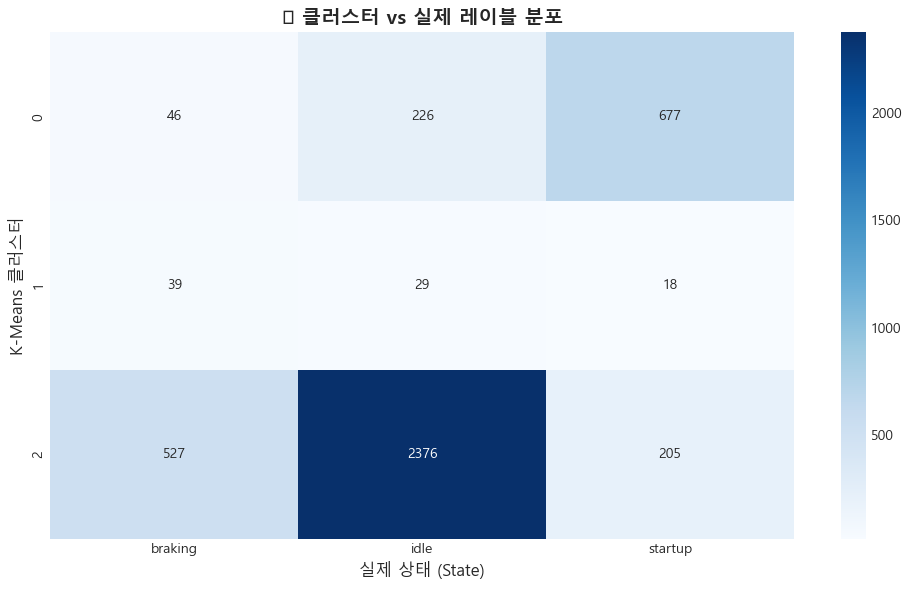


💡 클러스터별 주요 구성:

  Cluster 0:
    startup: 677개 (71.3%)
    idle: 226개 (23.8%)
    braking: 46개 (4.8%)

  Cluster 1:
    braking: 39개 (45.3%)
    idle: 29개 (33.7%)
    startup: 18개 (20.9%)

  Cluster 2:
    idle: 2376개 (76.4%)
    braking: 527개 (17.0%)
    startup: 205개 (6.6%)


In [11]:
# ============================================================
# 클러스터-레이블 매칭 분석
# ============================================================

# 혼동 행렬: 클러스터 vs 실제 레이블
contingency = pd.crosstab(
    pd.Series(cluster_labels, name='Cluster'),
    pd.Series(y_state, name='State').map(lambda x: state_names[x])
)

print("\n📊 클러스터-레이블 교차표:")
print(contingency)

# 히트맵 시각화
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(
    contingency, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    ax=ax
)
ax.set_title('🔍 클러스터 vs 실제 레이블 분포', fontsize=14, fontweight='bold')
ax.set_xlabel('실제 상태 (State)', fontsize=12)
ax.set_ylabel('K-Means 클러스터', fontsize=12)
plt.tight_layout()
plt.show()

# 각 클러스터의 주요 레이블 분석
print("\n💡 클러스터별 주요 구성:")
for cluster_id in range(3):
    cluster_mask = cluster_labels == cluster_id
    states_in_cluster = y_state[cluster_mask]
    state_dist = Counter(states_in_cluster)
    
    total = sum(state_dist.values())
    print(f"\n  Cluster {cluster_id}:")
    for state_idx, count in sorted(state_dist.items(), key=lambda x: -x[1]):
        pct = count / total * 100
        print(f"    {state_names[state_idx]}: {count}개 ({pct:.1f}%)")


---
## 3. 1단계 모델: 상태(State) 분류

브레이크 상태 / 공회전 상태 / 시동 상태를 분류하는 모델을 학습합니다.


In [12]:
# ============================================================
# 데이터셋 클래스 정의
# ============================================================

from typing import Optional

class SoundDataset(Dataset):
    """차량 사운드 데이터셋"""
    
    def __init__(
        self,
        file_paths: list,
        labels: list,
        feature_extractor: AudioFeatureExtractor,
        augmentor: Optional[AudioAugmentor] = None,
        apply_spec_augment: bool = False,
        is_training: bool = True
    ):
        self.file_paths = file_paths
        self.labels = labels
        self.feature_extractor = feature_extractor
        self.augmentor = augmentor
        self.apply_spec_augment = apply_spec_augment
        self.is_training = is_training
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        
        features = self.feature_extractor.extract_for_cnn(str(file_path))
        
        if self.is_training and self.apply_spec_augment and self.augmentor is not None:
            features_2d = features[0]
            features_2d = self.augmentor.spec_augment(
                features_2d, num_freq_masks=2, num_time_masks=2,
                freq_mask_param=15, time_mask_param=35
            )
            features = features_2d[np.newaxis, ...]
        
        features_tensor = torch.FloatTensor(features)
        label_tensor = torch.LongTensor([label])[0]
        
        return features_tensor, label_tensor

print("✅ SoundDataset 클래스 정의 완료!")


✅ SoundDataset 클래스 정의 완료!


In [13]:
# ============================================================
# 1단계 모델 학습 데이터 준비
# ============================================================

# 데이터 분할
X_train_s, X_temp_s, y_train_s, y_temp_s = train_test_split(
    all_files, all_states,
    test_size=0.3,
    stratify=all_states,
    random_state=42
)

X_val_s, X_test_s, y_val_s, y_test_s = train_test_split(
    X_temp_s, y_temp_s,
    test_size=0.5,
    stratify=y_temp_s,
    random_state=42
)

print("📊 1단계 모델 (State 분류) 데이터 분할:")
print(f"  • 학습 셋: {len(X_train_s)}개")
print(f"  • 검증 셋: {len(X_val_s)}개")
print(f"  • 테스트 셋: {len(X_test_s)}개")
print(f"  • 클래스 수: 3개 (braking, idle, startup)")


📊 1단계 모델 (State 분류) 데이터 분할:
  • 학습 셋: 2900개
  • 검증 셋: 621개
  • 테스트 셋: 622개
  • 클래스 수: 3개 (braking, idle, startup)


In [14]:
# ============================================================
# 1단계 모델 학습
# ============================================================

# 증강기
aug_config = AugmentationConfig()
augmentor = AudioAugmentor(config=aug_config)

# 데이터셋 생성
BATCH_SIZE = 16

train_dataset_s = SoundDataset(
    file_paths=X_train_s, labels=y_train_s,
    feature_extractor=feature_extractor,
    augmentor=augmentor, apply_spec_augment=True, is_training=True
)

val_dataset_s = SoundDataset(
    file_paths=X_val_s, labels=y_val_s,
    feature_extractor=feature_extractor,
    augmentor=None, apply_spec_augment=False, is_training=False
)

test_dataset_s = SoundDataset(
    file_paths=X_test_s, labels=y_test_s,
    feature_extractor=feature_extractor,
    augmentor=None, apply_spec_augment=False, is_training=False
)

train_loader_s = DataLoader(train_dataset_s, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_s = DataLoader(val_dataset_s, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader_s = DataLoader(test_dataset_s, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✅ DataLoader 생성 완료!")
print(f"   학습 배치: {len(train_loader_s)}, 검증 배치: {len(val_loader_s)}")


✅ DataLoader 생성 완료!
   학습 배치: 182, 검증 배치: 39


In [15]:
# ============================================================
# 1단계 CRNN 모델 정의 및 학습
# ============================================================

NUM_STATES = 3  # braking, idle, startup

# 모델 생성
state_model = SoundClassifierCRNN(
    num_classes=NUM_STATES,
    in_channels=1,
    cnn_channels=[32, 64, 128],
    rnn_hidden_size=128,
    rnn_num_layers=2,
    dropout=0.3,
    bidirectional=True
)
state_model = state_model.to(device)

print("🏗️ 1단계 모델 (State 분류):")
print(f"   클래스: {state_names}")
total_params = sum(p.numel() for p in state_model.parameters())
print(f"   파라미터: {total_params:,}")

# 클래스 가중치
state_counts_list = [state_counts[i] for i in range(NUM_STATES)]
class_weights = 1.0 / torch.FloatTensor(state_counts_list)
class_weights = class_weights / class_weights.sum() * NUM_STATES

# 학습 설정
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = create_optimizer(state_model, 'adamw', lr=1e-3, weight_decay=0.01)
scheduler = create_scheduler(optimizer, 'cosine', epochs=20)

# 체크포인트 디렉토리
checkpoint_dir = Path('../checkpoints')
checkpoint_dir.mkdir(exist_ok=True)

# Trainer
state_trainer = Trainer(
    model=state_model,
    train_loader=train_loader_s,
    val_loader=val_loader_s,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=str(device),
    save_dir=str(checkpoint_dir),
    experiment_name='state_classifier',
    use_amp=(device.type == 'cuda')
)

# 학습
print("\n🚀 1단계 모델 학습 시작!")
print("=" * 60)

state_history = state_trainer.train(
    epochs=20,
    early_stopping_patience=7,
    save_best=True,
    verbose=True
)

print("\n✅ 1단계 모델 학습 완료!")


🏗️ 1단계 모델 (State 분류):
   클래스: ['braking', 'idle', 'startup']
   파라미터: 2,785,220

🚀 1단계 모델 학습 시작!

Starting training: state_classifier
Device: cpu
Total epochs: 20



Training: 100%|██████████| 182/182 [05:06<00:00,  1.68s/it, loss=1.4667, acc=51.55%]


Epoch [1/20]
  Train Loss: 0.9883 | Train Acc: 51.55%
  Val Loss: 0.9051 | Val Acc: 66.02%
  LR: 0.001000
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [05:28<00:00,  1.81s/it, loss=1.3957, acc=60.00%]


Epoch [2/20]
  Train Loss: 0.8441 | Train Acc: 60.00%
  Val Loss: 0.7770 | Val Acc: 55.88%
  LR: 0.000994
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [04:54<00:00,  1.62s/it, loss=0.7169, acc=65.07%]


Epoch [3/20]
  Train Loss: 0.7816 | Train Acc: 65.07%
  Val Loss: 0.6445 | Val Acc: 66.18%
  LR: 0.000976
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [04:39<00:00,  1.54s/it, loss=0.4585, acc=67.00%]


Epoch [4/20]
  Train Loss: 0.7373 | Train Acc: 67.00%
  Val Loss: 0.5919 | Val Acc: 77.46%
  LR: 0.000946
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [04:43<00:00,  1.56s/it, loss=1.2597, acc=70.45%]


Epoch [5/20]
  Train Loss: 0.6674 | Train Acc: 70.45%
  Val Loss: 0.5423 | Val Acc: 76.33%
  LR: 0.000905
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [04:44<00:00,  1.56s/it, loss=0.9805, acc=71.28%]


Epoch [6/20]
  Train Loss: 0.6230 | Train Acc: 71.28%
  Val Loss: 0.5136 | Val Acc: 76.17%
  LR: 0.000854
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [04:47<00:00,  1.58s/it, loss=0.3459, acc=73.07%]


Epoch [7/20]
  Train Loss: 0.6143 | Train Acc: 73.07%
  Val Loss: 0.5040 | Val Acc: 74.56%
  LR: 0.000794
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [05:12<00:00,  1.72s/it, loss=0.9691, acc=74.17%]


Epoch [8/20]
  Train Loss: 0.5845 | Train Acc: 74.17%
  Val Loss: 0.4468 | Val Acc: 78.42%
  LR: 0.000727
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [04:45<00:00,  1.57s/it, loss=0.8064, acc=75.17%]


Epoch [9/20]
  Train Loss: 0.5750 | Train Acc: 75.17%
  Val Loss: 0.5217 | Val Acc: 80.84%
  LR: 0.000655



Training: 100%|██████████| 182/182 [04:43<00:00,  1.56s/it, loss=1.5616, acc=75.79%]


Epoch [10/20]
  Train Loss: 0.5553 | Train Acc: 75.79%
  Val Loss: 0.4714 | Val Acc: 80.68%
  LR: 0.000579



Training: 100%|██████████| 182/182 [04:46<00:00,  1.57s/it, loss=0.9465, acc=78.34%]


Epoch [11/20]
  Train Loss: 0.5189 | Train Acc: 78.34%
  Val Loss: 0.5079 | Val Acc: 73.91%
  LR: 0.000501



Training: 100%|██████████| 182/182 [04:46<00:00,  1.57s/it, loss=1.1433, acc=77.83%]


Epoch [12/20]
  Train Loss: 0.5313 | Train Acc: 77.83%
  Val Loss: 0.3881 | Val Acc: 86.63%
  LR: 0.000422
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [04:55<00:00,  1.62s/it, loss=0.8616, acc=79.93%]


Epoch [13/20]
  Train Loss: 0.5105 | Train Acc: 79.93%
  Val Loss: 0.3689 | Val Acc: 83.57%
  LR: 0.000346
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [04:57<00:00,  1.63s/it, loss=1.0997, acc=81.41%]


Epoch [14/20]
  Train Loss: 0.4800 | Train Acc: 81.41%
  Val Loss: 0.4021 | Val Acc: 82.77%
  LR: 0.000274



Training: 100%|██████████| 182/182 [04:43<00:00,  1.56s/it, loss=0.1422, acc=81.34%]


Epoch [15/20]
  Train Loss: 0.4556 | Train Acc: 81.34%
  Val Loss: 0.3320 | Val Acc: 85.35%
  LR: 0.000207
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [04:53<00:00,  1.61s/it, loss=0.1015, acc=81.21%]


Epoch [16/20]
  Train Loss: 0.4615 | Train Acc: 81.21%
  Val Loss: 0.3360 | Val Acc: 85.51%
  LR: 0.000147



Training: 100%|██████████| 182/182 [05:25<00:00,  1.79s/it, loss=0.5848, acc=82.48%]


Epoch [17/20]
  Train Loss: 0.4530 | Train Acc: 82.48%
  Val Loss: 0.3382 | Val Acc: 86.15%
  LR: 0.000096



Training: 100%|██████████| 182/182 [05:16<00:00,  1.74s/it, loss=0.2148, acc=83.62%]


Epoch [18/20]
  Train Loss: 0.4197 | Train Acc: 83.62%
  Val Loss: 0.3183 | Val Acc: 88.57%
  LR: 0.000055
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [05:06<00:00,  1.69s/it, loss=0.0715, acc=83.69%]


Epoch [19/20]
  Train Loss: 0.4240 | Train Acc: 83.69%
  Val Loss: 0.3150 | Val Acc: 86.31%
  LR: 0.000025
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [04:53<00:00,  1.61s/it, loss=1.1616, acc=82.79%]


Epoch [20/20]
  Train Loss: 0.4244 | Train Acc: 82.79%
  Val Loss: 0.3272 | Val Acc: 86.47%
  LR: 0.000007


✅ 1단계 모델 학습 완료!


In [ ]:
# ============================================================
# 1단계 모델 평가
# ============================================================

def evaluate_model(model, test_loader, device, class_names, model_name="Model"):
    """모델 평가"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_x, batch_y in tqdm(test_loader, desc=f"Evaluating {model_name}"):
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.numpy())
    
    accuracy = 100 * sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
    
    print(f"\n{'='*60}")
    print(f"📊 {model_name} 테스트 결과")
    print(f"{'='*60}")
    print(f"정확도: {accuracy:.2f}%")
    
    print("\n📋 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
    
    # 혼동 행렬
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return accuracy, all_preds, all_labels

# Best 모델 로드
state_best_path = checkpoint_dir / 'state_classifier_best_model.pt'
if state_best_path.exists():
    checkpoint = torch.load(state_best_path, map_location=device)
    state_model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Best 모델 로드 완료!")

# 평가
state_acc, state_preds, state_labels = evaluate_model(
    state_model, test_loader_s, device, state_names, "State Classifier (1단계)"
)


✅ Best 모델 로드 완료!


Evaluating State Classifier (1단계): 100%|██████████| 39/39 [00:29<00:00,  1.32it/s]



📊 State Classifier (1단계) 테스트 결과
정확도: 89.07%

📋 Classification Report:


InvalidParameterError: The 'zero_division' parameter of classification_report must be a float among {0.0, 1.0}, numpy.nan or a str among {'warn'}. Got '0' instead.

---
## 4. 2단계 모델: 세부 문제 분류

각 상태별로 세부 문제를 분류하는 모델을 학습합니다.
- 브레이크: normal_brakes, worn_out_brakes
- 공회전: normal_engine_idle, low_oil, power_steering, serpentine_belt, combined/*
- 시동: normal_engine_startup, bad_ignition, dead_battery


In [ ]:
# ============================================================
# 상태별 데이터 분리
# ============================================================

# 상태별 데이터 분리
state_data = {0: [], 1: [], 2: []}  # braking, idle, startup

for file_path, state, problem in zip(all_files, all_states, all_problems):
    state_data[state].append((file_path, problem))

print("📊 상태별 데이터 분포:")
for state_idx, name in enumerate(state_names):
    print(f"  {name}: {len(state_data[state_idx])}개")


In [ ]:
# ============================================================
# 2단계 모델 학습 함수
# ============================================================

def train_sub_classifier(
    state_name: str,
    state_idx: int,
    data: list,
    feature_extractor: AudioFeatureExtractor,
    device: torch.device,
    checkpoint_dir: Path,
    epochs: int = 20
):
    """특정 상태의 세부 문제 분류 모델 학습"""
    print(f"\n{'='*60}")
    print(f"🔧 {state_name.upper()} 상태 세부 분류 모델 학습")
    print(f"{'='*60}")
    
    # 파일 경로와 레이블 분리
    files = [d[0] for d in data]
    problems = [d[1] for d in data]
    
    # 레이블 인코딩
    unique_problems = sorted(set(problems))
    problem_to_idx = {p: i for i, p in enumerate(unique_problems)}
    idx_to_problem = {i: p for p, i in problem_to_idx.items()}
    labels = [problem_to_idx[p] for p in problems]
    
    num_classes = len(unique_problems)
    print(f"\n📊 클래스 ({num_classes}개):")
    label_counts = Counter(labels)
    for idx, problem in idx_to_problem.items():
        short_name = problem.split('/')[-1]
        print(f"  [{idx}] {short_name}: {label_counts[idx]}개")
    
    # 데이터 분할
    X_train, X_temp, y_train, y_temp = train_test_split(
        files, labels, test_size=0.3, stratify=labels, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )
    
    print(f"\n📊 데이터 분할: Train {len(X_train)}, Val {len(X_val)}, Test {len(X_test)}")
    
    # 데이터셋 생성
    aug_config = AugmentationConfig()
    augmentor = AudioAugmentor(config=aug_config)
    
    train_dataset = SoundDataset(
        file_paths=X_train, labels=y_train,
        feature_extractor=feature_extractor,
        augmentor=augmentor, apply_spec_augment=True, is_training=True
    )
    val_dataset = SoundDataset(
        file_paths=X_val, labels=y_val,
        feature_extractor=feature_extractor,
        augmentor=None, apply_spec_augment=False, is_training=False
    )
    test_dataset = SoundDataset(
        file_paths=X_test, labels=y_test,
        feature_extractor=feature_extractor,
        augmentor=None, apply_spec_augment=False, is_training=False
    )
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
    
    # 모델 생성
    model = SoundClassifierCRNN(
        num_classes=num_classes,
        in_channels=1,
        cnn_channels=[32, 64, 128],
        rnn_hidden_size=128,
        rnn_num_layers=2,
        dropout=0.3,
        bidirectional=True
    )
    model = model.to(device)
    
    # 클래스 가중치
    class_counts_list = [label_counts.get(i, 1) for i in range(num_classes)]
    class_weights = 1.0 / torch.FloatTensor(class_counts_list)
    class_weights = class_weights / class_weights.sum() * num_classes
    
    # 학습 설정
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = create_optimizer(model, 'adamw', lr=1e-3, weight_decay=0.01)
    scheduler = create_scheduler(optimizer, 'cosine', epochs=epochs)
    
    # Trainer
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=str(device),
        save_dir=str(checkpoint_dir),
        experiment_name=f'{state_name}_sub_classifier',
        use_amp=(device.type == 'cuda')
    )
    
    # 학습
    print(f"\n🚀 학습 시작!")
    history = trainer.train(
        epochs=epochs,
        early_stopping_patience=7,
        save_best=True,
        verbose=True
    )
    
    # Best 모델 로드
    best_path = checkpoint_dir / f'{state_name}_sub_classifier_best_model.pt'
    if best_path.exists():
        checkpoint = torch.load(best_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
    
    # 평가
    class_names = [idx_to_problem[i].split('/')[-1] for i in range(num_classes)]
    accuracy, preds, labels_result = evaluate_model(
        model, test_loader, device, class_names, f"{state_name.upper()} Sub-Classifier"
    )
    
    return {
        'model': model,
        'history': history,
        'accuracy': accuracy,
        'problem_to_idx': problem_to_idx,
        'idx_to_problem': idx_to_problem,
        'class_names': class_names
    }

print("✅ 학습 함수 정의 완료!")


In [ ]:
# ============================================================
# 2단계 모델 1: 브레이크 상태 세부 분류
# ============================================================

braking_result = train_sub_classifier(
    state_name='braking',
    state_idx=0,
    data=state_data[0],
    feature_extractor=feature_extractor,
    device=device,
    checkpoint_dir=checkpoint_dir,
    epochs=20
)


In [ ]:
# ============================================================
# 2단계 모델 2: 공회전 상태 세부 분류
# ============================================================

idle_result = train_sub_classifier(
    state_name='idle',
    state_idx=1,
    data=state_data[1],
    feature_extractor=feature_extractor,
    device=device,
    checkpoint_dir=checkpoint_dir,
    epochs=20
)


In [ ]:
# ============================================================
# 2단계 모델 3: 시동 상태 세부 분류
# ============================================================

startup_result = train_sub_classifier(
    state_name='startup',
    state_idx=2,
    data=state_data[2],
    feature_extractor=feature_extractor,
    device=device,
    checkpoint_dir=checkpoint_dir,
    epochs=20
)


---
## 5. 최종 결과 요약


In [ ]:
# ============================================================
# 전체 결과 요약
# ============================================================

print("=" * 70)
print("🎉 계층적 분류 모델 학습 완료!")
print("=" * 70)

print(f"""
📊 모델 성능 요약:

┌─────────────────────────────────────────────────────────────────┐
│ 1단계: State 분류 모델                                           │
│   • 클래스: braking, idle, startup (3개)                         │
│   • 테스트 정확도: {state_acc:.2f}%                                │
│   • 저장 경로: checkpoints/state_classifier_best_model.pt        │
├─────────────────────────────────────────────────────────────────┤
│ 2단계: 세부 분류 모델                                            │
│                                                                 │
│   [Braking] 브레이크 상태 세부 분류                              │
│     • 클래스: {braking_result['class_names']}
│     • 테스트 정확도: {braking_result['accuracy']:.2f}%
│                                                                 │
│   [Idle] 공회전 상태 세부 분류                                   │
│     • 클래스: {len(idle_result['class_names'])}개
│     • 테스트 정확도: {idle_result['accuracy']:.2f}%
│                                                                 │
│   [Startup] 시동 상태 세부 분류                                  │
│     • 클래스: {startup_result['class_names']}
│     • 테스트 정확도: {startup_result['accuracy']:.2f}%
└─────────────────────────────────────────────────────────────────┘

🔍 군집 분석 결과:
  • Silhouette Score: {silhouette:.4f}
  • Adjusted Rand Index: {ari:.4f}
  • Normalized Mutual Info: {nmi:.4f}

📁 저장된 모델:
  • checkpoints/state_classifier_best_model.pt
  • checkpoints/braking_sub_classifier_best_model.pt
  • checkpoints/idle_sub_classifier_best_model.pt
  • checkpoints/startup_sub_classifier_best_model.pt
""")
print("=" * 70)


In [ ]:
# ============================================================
# 계층적 추론 예시
# ============================================================

def hierarchical_predict(audio_path, state_model, sub_models, feature_extractor, device):
    """
    계층적 분류 수행
    1단계: 상태(State) 예측
    2단계: 해당 상태의 세부 문제 예측
    """
    # 피처 추출
    features = feature_extractor.extract_for_cnn(str(audio_path))
    input_tensor = torch.FloatTensor(features).unsqueeze(0).to(device)
    
    # 1단계: 상태 예측
    state_model.eval()
    with torch.no_grad():
        state_output = state_model(input_tensor)
        state_probs = torch.softmax(state_output, dim=1)
        state_pred = state_output.argmax(dim=1).item()
        state_conf = state_probs[0, state_pred].item() * 100
    
    state_name = state_names[state_pred]
    
    # 2단계: 세부 문제 예측
    sub_model_info = sub_models[state_pred]
    sub_model = sub_model_info['model']
    idx_to_problem = sub_model_info['idx_to_problem']
    
    sub_model.eval()
    with torch.no_grad():
        sub_output = sub_model(input_tensor)
        sub_probs = torch.softmax(sub_output, dim=1)
        sub_pred = sub_output.argmax(dim=1).item()
        sub_conf = sub_probs[0, sub_pred].item() * 100
    
    problem_name = idx_to_problem[sub_pred].split('/')[-1]
    
    return {
        'state': state_name,
        'state_confidence': state_conf,
        'problem': problem_name,
        'problem_confidence': sub_conf
    }

# 서브 모델 딕셔너리
sub_models = {
    0: braking_result,
    1: idle_result,
    2: startup_result
}

# 테스트 샘플로 예측 시연
import random
test_samples = random.sample(list(zip(X_test_s, y_test_s)), min(5, len(X_test_s)))

print("🧪 계층적 추론 예시:")
print("=" * 60)

for sample_path, true_state in test_samples:
    result = hierarchical_predict(
        sample_path, state_model, sub_models, feature_extractor, device
    )
    
    true_state_name = state_names[true_state]
    is_correct = "✅" if result['state'] == true_state_name else "❌"
    
    print(f"\n파일: {sample_path.name}")
    print(f"  실제 상태: {true_state_name}")
    print(f"  예측 결과: {is_correct}")
    print(f"    1단계: {result['state']} ({result['state_confidence']:.1f}%)")
    print(f"    2단계: {result['problem']} ({result['problem_confidence']:.1f}%)")
